In [ ]:
# Import packages
import os 
import warnings
import gc

import pandas as pd 
import numpy as np 
from plotly.subplots import make_subplots
import plotly.express as px 
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Configuration
warnings.simplefilter('ignore')
pd.set_option('max_columns', 50)

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: Test_data.csv           
  inflating: Train_data.csv          


In [ ]:
train = pd.read_csv("Train_data.csv")
test = pd.read_csv("Test_data.csv")

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


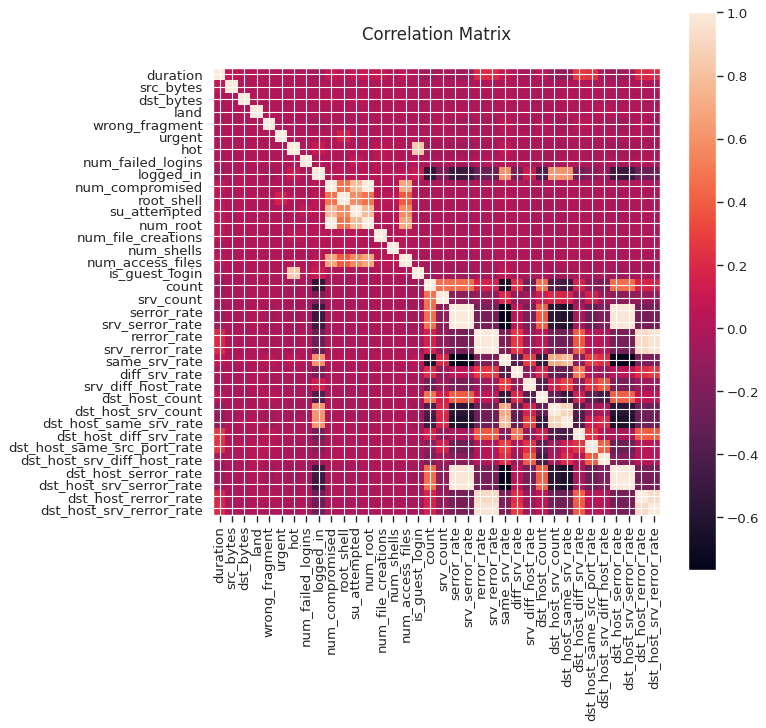

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()
plotCorrelationMatrix(train, 9)

In [ ]:
# Descriptive statistics
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [ ]:
#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
# Attack Class Distribution
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

In [ ]:
df = train.copy()

In [ ]:
# Utility functions 
def describe(df, stats):
    '''Describe the basic information of the raw dataframe.
    
    Parameters:
        df: pd.DataFrame, raw dataframe to be analyzed
        stats: boolean, whether to get descriptive statistics 
    
    Return:
        None
    '''
    df_ = df.copy(deep=True)   # Copy of the raw dataframe
    n_features = df_.shape[1]
    if n_features > pd.get_option("max_columns"):
        # If the feature (column) number is greater than max number of columns displayed
        warnings.warn("Please reset the display-related options max_columns \
                      to enable the complete display.", 
                      UserWarning) 
    print("=====Basic information=====")
    display(df_.info())
    get_nan_ratios(df_)
    if stats:
        print("=====Description=====")
        numeric_col_num = df_.select_dtypes(include=np.number).shape[1]   # Number of cols in numeric type
        if numeric_col_num != 0:
            display(df_.describe())
        else:
            print("There's no description of numeric data to display!")
    del df_
    gc.collect()

def get_nan_ratios(df):
    '''Get NaN ratios of columns with NaN values.
    
    Parameters:
        df: pd.DataFrame, raw dataframe to be analyzed
        
    Return:
        None
    '''
    df_ = df.copy()   # Copy of the raw dataframe
    nan_ratios = df_.isnull().sum() / df_.shape[0] * 100   # Ratios of value nan in each column
    nan_ratios = pd.DataFrame([df_.columns, nan_ratios]).T   # Take transpose 
    nan_ratios.columns = ["Columns", "NaN ratios"]
    nan_ratios = nan_ratios[nan_ratios["NaN ratios"] != 0.0]
    print("=====NaN ratios of columns with NaN values=====")
    if len(nan_ratios) == 0:
        print("There isn't any NaN value in the dataset!")
    else:
        display(nan_ratios)
    del df_
    gc.collect() 

# DatasetSplit

In [ ]:
X, y = df.iloc[:, :-1], df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
print(f"Shape of X_train: {X_train.shape}\nShape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (20153, 40)
Shape of X_test: (5039, 40)
Shape of y_train: (20153,)
Shape of y_test: (5039,)


# EDA

In [ ]:
describe(X_train, stats=True)

=====Basic information=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20153 entries, 0 to 20152
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     20153 non-null  int64  
 1   protocol_type                20153 non-null  object 
 2   service                      20153 non-null  object 
 3   flag                         20153 non-null  object 
 4   src_bytes                    20153 non-null  int64  
 5   dst_bytes                    20153 non-null  int64  
 6   land                         20153 non-null  int64  
 7   wrong_fragment               20153 non-null  int64  
 8   urgent                       20153 non-null  int64  
 9   hot                          20153 non-null  int64  
 10  num_failed_logins            20153 non-null  int64  
 11  logged_in                    20153 non-null  int64  
 12  num_compromised              20153 non-null  i

None

=====NaN ratios of columns with NaN values=====
There isn't any NaN value in the dataset!
=====Description=====


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,20153.000000,2.015300e+04,2.015300e+04,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.0,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.00000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000,20153.000000
mean,319.905225,2.758359e+04,3.072598e+03,0.000099,0.024562,0.000050,0.198779,0.000943,0.393788,0.265568,0.001588,0.001389,0.294944,0.016623,0.000397,0.004863,0.0,0.009279,83.799037,27.489456,0.284127,0.281405,0.119205,0.120859,0.661645,0.062943,0.09714,182.732546,114.918027,0.519122,0.082534,0.147954,0.031860,0.283940,0.277852,0.118341,0.119213
std,2769.236155,2.693387e+06,7.610985e+04,0.009962,0.265343,0.007044,2.120404,0.036591,0.488601,11.544894,0.039817,0.049792,12.754684,0.575029,0.019920,0.107648,0.0,0.095882,113.923100,71.777480,0.446312,0.446599,0.319394,0.322927,0.439098,0.180297,0.25825,98.972485,110.526341,0.448677,0.186705,0.308454,0.109842,0.444379,0.444965,0.306336,0.317841
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.00000,85.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,255.000000,61.000000,0.500000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.780000e+02,5.210000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,142.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.00000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.000000,30.000000,3.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## There are three categorical features in the dataset, including protocol type, service and flag

In [ ]:
cat_features = ['protocol_type', 'service', 'flag']
for f in cat_features:
    print(f"=====Unique values of {f}=====")
    unique_vals = X_train[f].unique()
    print(unique_vals)
    print(f"Number of unique values: {len(unique_vals)}\n")

=====Unique values of protocol_type=====
['icmp' 'tcp' 'udp']
Number of unique values: 3

=====Unique values of service=====
['eco_i' 'private' 'other' 'bgp' 'http' 'ecr_i' 'domain_u' 'smtp' 'ldap'
 'auth' 'daytime' 'ftp' 'ftp_data' 'exec' 'time' 'finger' 'uucp_path'
 'netstat' 'link' 'urp_i' 'telnet' 'whois' 'csnet_ns' 'klogin' 'imap4'
 'ctf' 'efs' 'sunrpc' 'Z39_50' 'domain' 'echo' 'printer' 'netbios_ns'
 'discard' 'nnsp' 'ntp_u' 'login' 'hostnames' 'courier' 'iso_tsap'
 'netbios_dgm' 'uucp' 'http_443' 'ssh' 'vmnet' 'supdup' 'gopher' 'sql_net'
 'name' 'systat' 'kshell' 'X11' 'mtp' 'pop_2' 'shell' 'pop_3'
 'netbios_ssn' 'IRC' 'red_i' 'nntp' 'remote_job' 'rje' 'pm_dump' 'tim_i'
 'urh_i']
Number of unique values: 65

=====Unique values of flag=====
['SF' 'S0' 'REJ' 'RSTO' 'RSTR' 'S2' 'S3' 'SH' 'S1' 'RSTOS0' 'OTH']
Number of unique values: 11



## Ratio of Each Unique Value

In [ ]:
for f in cat_features:
    val_counts = X_train[f].value_counts()
    fig = go.Figure()
    fig.add_trace(go.Pie(
        labels=val_counts.index,
        values=val_counts
    ))
    fig.update_traces(textposition='inside') 
    fig.update_layout(
        title=f"Pie Chart of {f}",
        uniformtext_minsize=12, 
        uniformtext_mode='hide'
    )
    fig.show()

## Univariate Distribution

In [ ]:
numeric_features = [col for col in X_train.columns if col not in cat_features]

fig = make_subplots(rows=10, cols=4, subplot_titles=numeric_features)
for i in range(1, 11):
    for j in range(1, 5):
        feature_idx = 4 * (i-1) + (j-1)
        if feature_idx == len(numeric_features):
            break
        feature = numeric_features[feature_idx]
        feature_series = X_train[feature]
        sub_fig = go.Histogram(x=feature_series, name=feature)
        fig.add_trace(
            sub_fig,
            row=i,
            col=j
        )
        
fig.update_layout(height=1200, title_text="Univariate Distribution of Numeric Features") 
fig.show()

## Bivariate Distribution

In [ ]:
n_samples = X_train.shape[0]   # Total number of samples

# Get the proportion of the value with the most count in each feature
max_proportions = pd.DataFrame()
for f in numeric_features:
    feature_series = X_train[f]
    max_proportion = np.max(feature_series.value_counts()) / n_samples
    max_proportions[f] = [max_proportion]
max_proportions.index = ["Max Proportion"]

# Get the variance of each feature 
vars = pd.DataFrame(X_train.var()).T
vars.index = ["Variance"]

disp_and_var = max_proportions.append(vars)
print("=====Statistical dispersion and variation=====")
display(disp_and_var)
# Filter out features with high "max proportion" or low "variance"
disp_and_var_T = disp_and_var.T   # Take the transpose
features_remained = disp_and_var_T[(disp_and_var_T['Max Proportion'] < 0.99) & disp_and_var_T['Variance'] > 0.001].index.tolist()
X_train = X_train.loc[:, features_remained]
print(f"After filtering, there are {len(features_remained)} numeric features remained.")

# Plot bivariate distributions 
features_picked = features_remained[-5:]
df_train = X_train.loc[:, features_picked]
df_train['gt'] = y_train
fig = px.scatter_matrix(df_train, 
                        dimensions=features_picked,
                        color="gt", 
                        symbol="gt")
fig.update_traces(diagonal_visible=False)
fig.update_layout(height=1200, title_text="Bivariate Distribution of Numeric Feature Pairs (Randomly Picked)") 
fig.show()

=====Statistical dispersion and variation=====


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Max Proportion,9.189203e-01,3.897187e-01,5.385799e-01,0.999901,0.990919,0.99995,0.979011,0.999206,0.606212,0.988835,0.998412,0.999156,0.994046,0.997320,0.999603,0.996626,1.0,0.990721,0.220315,0.20265,0.690021,0.705652,0.872029,0.870838,0.610331,0.606064,0.773086,0.590929,0.282290,0.385898,0.369523,0.501613,0.690269,0.644222,0.676227,0.819977,0.845780
Variance,7.668669e+06,7.254334e+12,5.792709e+09,0.000099,0.070407,0.00005,4.496114,0.001339,0.238731,133.284571,0.001585,0.002479,162.681960,0.330659,0.000397,0.011588,0.0,0.009193,12978.472812,5152.00665,0.199194,0.199451,0.102013,0.104282,0.192807,0.032507,0.066693,9795.552820,12216.072081,0.201311,0.034859,0.095144,0.012065,0.197473,0.197994,0.093842,0.101023


After filtering, there are 25 numeric features remained.


# KFold Cross Validation with RandomForestClassifier

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Evaluate the model performance using KFold CV
kf = KFold(5, shuffle=True, random_state=42)
models = []   # Trained model record
fi = []   # Feature importance record
val_metrics = []   # Evaluation metrics record
fold = 0

for train_idx, val_idx in kf.split(X_train):
    print(f"=====Evaluation of fold{fold} starts=====")
    # Prepare the training and validation sets
    X_train_, X_val = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
    y_train_, y_val = y_train[train_idx], y_train[val_idx]
    
    # Train the classifier (rfc)
    rfc = RandomForestClassifier(n_estimators=500)
    rfc.fit(X_train_, y_train_)
    models.append(rfc)    # Record the trained model
    fi.append(rfc.feature_importances_)   # Record the feature importance
    
    # Predict and evaluate the performance
    y_val_pred = rfc.predict(X_val)
    p_r_f1_mac = list(precision_recall_fscore_support(y_val, y_val_pred, average='macro')[:3])
    p_r_f1_mic = list(precision_recall_fscore_support(y_val, y_val_pred, average='micro')[:3])
    p_r_f1_wei = list(precision_recall_fscore_support(y_val, y_val_pred, average='weighted')[:3])
    val_metrics.append([p_r_f1_mac, p_r_f1_mic, p_r_f1_wei])   # Concatenate the evaluation metrics and record
    print(f"=====Classification Report=====\n{classification_report(y_val, y_val_pred)}")
    
    print(f"=====Evaluation of fold{fold} finishes=====\n")
    fold += 1

=====Evaluation of fold0 starts=====
=====Classification Report=====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1872
           1       1.00      1.00      1.00      2159

    accuracy                           1.00      4031
   macro avg       1.00      1.00      1.00      4031
weighted avg       1.00      1.00      1.00      4031

=====Evaluation of fold0 finishes=====

=====Evaluation of fold1 starts=====
=====Classification Report=====
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1894
           1       0.99      1.00      1.00      2137

    accuracy                           1.00      4031
   macro avg       1.00      1.00      1.00      4031
weighted avg       1.00      1.00      1.00      4031

=====Evaluation of fold1 finishes=====

=====Evaluation of fold2 starts=====
=====Classification Report=====
              precision    recall  f1-score   support

    

In [ ]:
# Summarize the avarage performance in KFold CV
avg_metrics = np.mean(val_metrics, axis=0)
print("=====Average evaluatin metrics over 5 folds=====")
for i, method in enumerate(['Macro', 'Micro', 'Weighted']):
    print(f"=====Metrics {method}=====")
    print(f"Precision = {avg_metrics[i][0]} | Recall = {avg_metrics[i][1]} | F1-score = {avg_metrics[i][2]}")

=====Average evaluatin metrics over 5 folds=====
=====Metrics Macro=====
Precision = 0.9963522550826147 | Recall = 0.9960767685026862 | F1-score = 0.996209636173365
=====Metrics Micro=====
Precision = 0.9962288418601988 | Recall = 0.9962288418601988 | F1-score = 0.9962288418601988
=====Metrics Weighted=====
Precision = 0.996237400784359 | Recall = 0.9962288418601988 | F1-score = 0.9962282902677891


# Splitting the Train set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("class", axis=1), df["class"], test_size=0.3, random_state=45)

In [ ]:
X_train.drop(['is_host_login'], axis=1, inplace=True)
X_test.drop(['is_host_login'], axis=1, inplace=True)

# Encoding the Target variable

In [ ]:
# Encoding target class to 0 and 1
y_train = y_train.apply(lambda x: 1 if x=="anomaly" else 0)
y_test = y_test.apply(lambda x: 1 if x=="anomaly" else 0)

In [ ]:
# Custom Label Encoder for handling unknown values
class LabelEncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, data):
        self.label_encoder = self.label_encoder.fit(list(data) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self

    def transform(self, data):
        new_data = list(data)
        for unique_item in np.unique(data):
            if unique_item not in self.label_encoder.classes_:
                new_data = ['Unknown' if x==unique_item else x for x in new_data]
        return self.label_encoder.transform(new_data)

# Label Encoding

In [ ]:
le = LabelEncoderExt()

# encode the selected columns
for col in X_train.select_dtypes("object"):
  le.fit(X_train[col])
  X_train[col] = le.transform(X_train[col])
  X_test[col] = le.transform(X_test[col])

In [ ]:
from sklearn.preprocessing import StandardScaler
# for encoding
from sklearn.preprocessing import LabelEncoder
# for feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

scaler = StandardScaler()
# store the columns
cols = X_train.columns

# transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = cols)

In [ ]:
estimator = RandomForestClassifier()
selector = RFE(estimator)
selector.fit(X_train_scaled, y_train)

X_train_scaled = selector.transform(X_train_scaled)
X_test_scaled = selector.transform(X_test_scaled)

# Feature Importance

In [ ]:
import itertools
# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(selector.get_support(), df.columns)]
selected_features = [v for i, v in feature_map if i==True]

In [ ]:
selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'hot',
 'logged_in',
 'is_guest_login',
 'count',
 'srv_rerror_rate',
 'same_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate']

# Initializing various Models

In [ ]:
# for model selection and training
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score

#SVC Model
svc = SVC(random_state=45)

# LogisticRegression Model
lr = LogisticRegression()

# Gaussian Naive Bayes Model
bnb = BernoulliNB()

# Train XGBoost Classifier
xgbc = XGBClassifier(eval_metric="logloss", random_state=45)

# Train LightGBM Classifier
lgbmc = LGBMClassifier(random_state=45)

In [ ]:
models = {}
models['SVC']= svc
models['LogisticRegression']= lr
models['Naive Bayes Classifier']= bnb
models['XGBoost Classifier']= xgbc
models['LightGBM Classifier']= lgbmc
scores = {}
for name in models:
  scores[name]={}
  for scorer in ['precision','recall']:
    scores[name][scorer] = cross_val_score(models[name], X_train_scaled, y_train, cv=10, scoring=scorer)

# Finding Best Recall and Precision

In [ ]:
def line(name):
  return '*'*(25-len(name)//2)

for name in models:
  print(line(name), name, 'Model Validation', line(name))

  for scorer in ['precision','recall']:
    mean = round(np.mean(scores[name][scorer])*100,2)
    stdev = round(np.std(scores[name][scorer])*100,2)
    print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
    print()

************************ SVC Model Validation ************************
Mean precision: 
 98.54 % +- 0.49

Mean recall: 
 99.08 % +- 0.34

**************** LogisticRegression Model Validation ****************
Mean precision: 
 94.63 % +- 0.93

Mean recall: 
 92.61 % +- 1.0

************** Naive Bayes Classifier Model Validation **************
Mean precision: 
 93.7 % +- 0.83

Mean recall: 
 83.23 % +- 1.17

**************** XGBoost Classifier Model Validation ****************
Mean precision: 
 99.73 % +- 0.2

Mean recall: 
 99.18 % +- 0.25

**************** LightGBM Classifier Model Validation ****************
Mean precision: 
 99.84 % +- 0.16

Mean recall: 
 99.58 % +- 0.19



In [ ]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100

# Plotting Precision and Recall of all Models

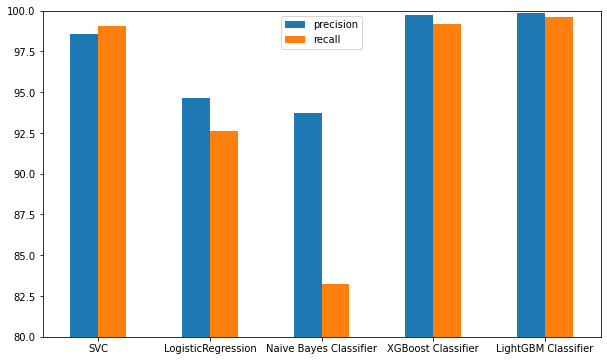

In [ ]:
scores.plot(kind = "bar",  ylim=[80,100], figsize=(10,6), rot=0)

In [ ]:
models = {}
models['SVC']= svc
models['LogisticRegression']= lr
models['Naive Bayes Classifier']= bnb
models['XGBoost Classifier']= xgbc
models['LightGBM Classifier']= lgbmc
preds={}
for name in models:
    models[name].fit(X_train_scaled, y_train)
    preds[name] = models[name].predict(X_test_scaled)
print("Predictions complete.")

Predictions complete.


In [ ]:
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["normal","anamoly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

************************ SVC Model Testing ************************
[[3932   65]
 [  29 3532]]
------------------------
              precision    recall  f1-score   support

      normal       0.99      0.98      0.99      3997
     anamoly       0.98      0.99      0.99      3561

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558

**************** LogisticRegression Model Testing ****************
[[3810  187]
 [ 256 3305]]
----------------
              precision    recall  f1-score   support

      normal       0.94      0.95      0.95      3997
     anamoly       0.95      0.93      0.94      3561

    accuracy                           0.94      7558
   macro avg       0.94      0.94      0.94      7558
weighted avg       0.94      0.94      0.94      7558

************** Naive Bayes Classifier Model Testing **************
[[3800  197]
 [ 596 2965]]
--------------
      

In [ ]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100

# Result of F1 Score on Test Set all 5 models

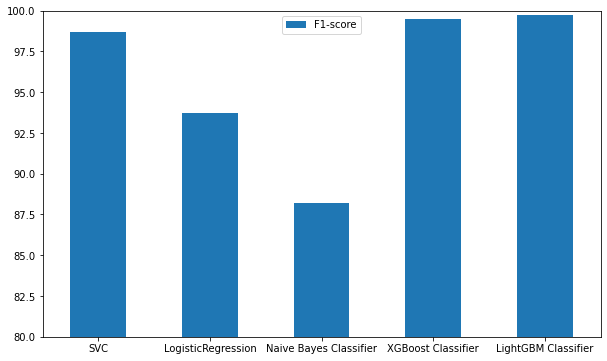

In [ ]:
f1s.plot(kind = "bar",  ylim=[80,100], figsize=(10,6), rot=0)